# Notebook for running Runge-Kutta4 solver on rate equations

Made as a summer student at CERN, at the [CRIS](http://isolde-cris.web.cern.ch/isolde-cris/index.html) experiment at [ISOLDE](http://isolde.web.cern.ch/) for simulation of spontaneous emission, absorption and stimulated emission in an atom. This can be related in rate equations for how the radiation interacts with matter.
1. Spontaneous emission 
2. Absorption
3. Stimulated emssion


This can be related trough the general rate equations with energy levels $i$ and $k$ where $i < k$

$\frac{dN_2}{dt} = N_1B_{12}\rho(\omega_{21}) - N_2B_{21} \rho(\omega_{21})- N_2A_{21}$


$\frac{dN_1}{dt} = -N_1B_{12}\rho(\omega_{21}) + N_2B_{21} \rho(\omega_{21}) +N_2A_{21} = - \frac{dN_2}{dt} $

This can be simulated for multiple levels, as long as the Einstein coefficients are available, it they are not, I have made the assumption that no transition is possible for consistency with experimental data available from [NIST Atomic Spectra Database Lines Data](https://physics.nist.gov/cgi-bin/ASD/lines1.pl?spectra=Sn+i&limits_type=0&low_w=&upp_w=&unit=1&de=0&java_out=Make+Grotrian+Diagram&format=0&line_out=0&en_unit=0&output=0&bibrefs=1&page_size=15&show_obs_wl=1&show_calc_wl=1&unc_out=1&order_out=0&max_low_enrg=&show_av=2&max_upp_enrg=&tsb_value=0&min_str=&A_out=0&intens_out=on&max_str=&allowed_out=1&forbid_out=1&min_accur=&min_intens=&conf_out=on&term_out=on&enrg_out=on&J_out=on)

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

In [202]:
# import stuff
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import re
import seaborn as sns
from scipy.constants import pi, speed_of_light, hbar, Boltzmann, Planck, elementary_charge
from scipy import signal
import readstuff as rs


In [78]:
params = {'legend.fontsize': 'large',
          'figure.figsize': (12, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)
plt.rcParams['figure.dpi']= 600

# Making a solver including pumping

Some information we need:

$laser_{linewidth} \approx 10$ GHz

$D_{beam} = 2-3$ mm

$f_{pumping} = 100 $ Hz (how many pulses the laser fires)

$t_{pump} \approx 10$ ns (length of a single laser pulse)

$FWHM \approx 20$ ns 

$ \sigma = \frac{FWHM}{2\sqrt{2\ln 2}}$


## Calculate the pumping coefficient $B$

Using that $\frac{A_{21}}{B_{21}} = \frac{\hbar\omega_{21}^3}{\pi^2c^3}$

and 

$g_1B_{12} = g_2B_{21}$

In [4]:
def getB(A,freq):
    return (A*pi**2*speed_of_light**3)/(hbar*(2*pi*freq)**3)

## Calculate $\rho_{max}$

In [5]:
def get_rho_tot(pulse_energy,beam_D,beam_duration):
    return pulse_energy/((pi*(0.5*beam_D))**2*beam_duration*speed_of_light)

def get_rho_max(laser_linewidth,pulse_energy,beam_D,beam_duration):
    return (1/(pi*laser_linewidth))*np.sqrt(np.log(2)/pi)*get_rho_tot(pulse_energy,beam_D,beam_duration)

### Find the time of flight (when the voltage is 40 kV)

In [10]:
mass = 119.9021947*1.6605e-27 # [kg]
E = 6.4087065e-15 #40000*1.602176565e-19 # [J]
l = 1.20 # [m]
v = np.sqrt(2*E/mass) # [m/s]
tof = l/v # [s]
# tof
stps = int(tof/1e-9)
TOF = stps*1e-9
# TOF
TOF2 = 1.35e-5
stps2 = int(TOF2/1e-9)
# stps2
# sigma =

## Find all the laser parameters needed
 $\lambda = v/f \implies f = v/\lambda \implies f = c/\lambda$

In [11]:
laser_width = 10*1e9 # [Hz]
pumpf = 100
tot_pump_per_sec = 1 - pumpf*10*1e-9 
beaml = 10*1e-9 # [s]
pumpav = tot_pump_per_sec/pumpf # how long th elaser is shut off at a time
pump_t0 = tof/2 # when the laser first fires
pE = 1e-3 # [J] pulse energy, measure instead
beamD = 3*1e-3 # [m] 

### Read in initial and final populations

In [12]:
def rd_fin(file,col=['level','pop']):
    pd.read_csv(col,names=col2,delimiter=';',float_precision='high').apply(pd.to_numeric,errors='coerce').sort_values(by='level').reset_index(drop=True)

In [13]:
def rd_init(file,col =['level','xs']):
    df = rd_fin(file,col)
    return rs.renorm(df).sort_values(by='level').reset_index(drop=True)

## Find the relative strength of decay

In [14]:
# Normalize the Einsteincoefficients
def normal_Einstein(dfa):
    df = dfa.copy()
    nlist = []
    for u in range(np.max(df.k)+1):
        upper = np.asarray(df[df.k == u].Aki)        
        if len(upper) > 0:
            nupper = upper/np.sum(upper)
            nlist.append(nupper)
    df['nAki'] = np.concatenate(np.array(nlist)).ravel()
    return df

## Find maximum possible distribution of each level as $t\rightarrow \infty$

In [15]:
def find_max(initialpopulation, dfa_norm):
    maxpop = np.array(initialpopulation['pop'].copy(),dtype=np.float128)
    dfa = dfa_norm.copy().sort_values(by='Ek').reset_index(drop=True)
    # first, find the levels that can decay multiple times trough different levels cascade
    decaymore = np.full(len(dfa_norm),False)
    
    for k, (ak, akrow) in enumerate(dfa.iterrows()):
        for i, (ai, airow) in enumerate(dfa.iterrows()):
            if k!=i and int(akrow['i']) == int(airow['k']):
                decaymore[ak] = True
                print('k',ak,'   ',int(akrow['k']),'>',int(akrow['i']),'>', int(airow['k']),'>',int(airow['i']))

    dfa['decaysmore'] = decaymore

    #let the upper level decay first
    fra = np.array(dfa['k']) # levels to decay from
    til = np.array(dfa['i']) # levels to decay to
    nAki = np.array(dfa['nAki'], dtype = np.float128)

    lendiff = fra.size # length of dN/dt 
    mfra = np.max(fra) + 1 # highest upper level + 1 for indexing
    mtil = np.max(til) + 1 # highest lower level + 1 for indexing
    armax = np.arange(mfra)
    armin = np.arange(mtil)
    gridfra = (np.mgrid[:mfra,:lendiff] == fra)[0] # grids for uniquely grouping transmission
    gridtil = (np.mgrid[:mtil,:lendiff] == til)[0]

    def f(N):  # N = population
        dN = np.zeros(len(N),dtype=np.float128)
        diff = N[fra]*nAki # dN/dt change in population
        # summing dN/dt for each unique level
        temp1 = (gridfra*diff).sum(axis=1) 
        temp2 = (gridtil*diff).sum(axis=1)
        dN[armax] -= temp1 # decay from upper levels
        dN[armin] += temp2 # decay to lower levels
        return dN
    
    for k, (a,arow) in enumerate(dfa.iterrows()):
        # letting the levels transmit to lower levels that can decay
        if arow.decaysmore == True:
            diff = initialpopulation['pop'][int(arow.k)]*arow.nAki
            maxpop[int(arow.k)] -= diff
            maxpop[int(arow.i)] += diff
            print(int(arow.k),int(arow.i))
    endpop = maxpop + f(maxpop)
    plt.vlines(initialpopulation['level'], np.zeros(len(endpop)), endpop, colors='k', linestyles='solid')
    plt.ylabel('Distribution')
    plt.xlabel(r'Wavenumber $[cm^{-1}]$')
    return endpop, dfa


## Find pumping routes

In [16]:
def pumpxtoy(x,y,df,tol=0.05):
    pxy = df[(((df.i == y)& (df.nAki > tol)) | ((df.i == x) & (df.nAki < 0.5))) & (df.nAki != 1)].sort_values(by='k').reset_index(drop=True)
    return pxy[pxy.duplicated(subset='k', keep=False)].sort_values(by=['Ek','i','nAki'])

## Calculate wavelengths

In [17]:
def add_wave(df):
    df['wavelength'] = normal_emc3['wavelength'] = (1/(df.Ek-df.Ei))*1e-2*1e9
    return df

## Solve the rate equations

In [228]:
def solver_vec(df_A,initialpop,stop,steps,pumpab=[1,2,3,5],pumpstart=0.5*tof, pumpduration=beaml,pumpoff=pumpav,laser_linewidth=laser_width,pulse_energy=pE,beam_D=beamD,pumping=False):
    time = np.linspace(0,stop,steps)
    dt = time[1] - time[0]; dt2 = dt*0.001
    laserfreq = np.asarray(speed_of_light/(df_A.wavelength*1e-9),dtype=np.float128)
#     print(laserfreq)
    rho_on = get_rho_max(laser_linewidth,pulse_energy,beam_D,pumpduration)
#     rho_on = get_new_rho(nu=laserfreq)
    population = np.array(initialpop['pop'].copy(),dtype=np.float128)
#     totsteps = stop/dt2
#     pop_ev = np.zeros((totsteps,len(population))) # get the time evolution of the population
#     print('rho',rho_on)
    fra = np.array(df_A['k']) # levels to decay from
    til = np.array(df_A['i']) # levels to decay to
    Aki = np.array(df_A['Aki'], dtype = np.float128)
    Akino = Aki.copy()
    Akino[pumpab] = 0
#     Akino[1:6] = 0
#     print(Akino)
#     print(Aki)
    lendiff = fra.size # length of dN/dt 
    mfra = np.max(fra) + 1 # highest upper level + 1 for indexing
    mtil = np.max(til) + 1 # highest lower level + 1 for indexing
    armax = np.arange(mfra); armin = np.arange(mtil)
    gridfra = (np.mgrid[:mfra,:lendiff] == fra)[0] # grids for uniquely grouping transmission
    gridtil = (np.mgrid[:mtil,:lendiff] == til)[0]

    # setting levels for pumping and finding the B coefficients
#     A_ba = df_A.iloc[pumpab]
#     print('aki', A_ba['Aki'])
#     B_ba = np.asarray(getB(np.asarray(A_ba['Aki']),laserfreq),dtype=np.float128)

    # degeneracy of from lower level a, to upper level b
#     gb = 2*newn2.sort_values(by='Ek').reset_index(drop=True).loc[pumpab].u_J + 1 
#     ga = 2*newn2.sort_values(by='Ek').reset_index(drop=True).loc[pumpab].l_J + 1#g = 2J+1
#     B_ab = np.asarray((gb/ga)*B_ba,dtype=np.float128)# replace with g factor when time comes
#     a = np.asarray(A_ba['i'],dtype=int); 
#     b = np.asarray(A_ba['k'],dtype=int)
#     print(a,b)
#     l_fra = np.array(A_ba['i']) # levels to pump from
#     l_til = np.array(A_ba['k']) # levels to pump to
#     l_Aki = np.array(A_ba['Aki'], dtype = np.float128)
#     print('fra', l_fra, 'til ',l_til)
#     l_lendiff = l_fra.size # length of dN/dt 
#     l_mfra = np.max(l_fra) + 1 # highest upper level + 1 for indexing
#     l_mtil = np.max(l_til) + 1 # highest lower level + 1 for indexing
#     l_armax = np.arange(l_mfra); l_armin = np.arange(l_mtil)
#     l_gridfra = (np.mgrid[:l_mfra,:l_lendiff] == l_fra)[0] # grids for uniquely grouping transmission
#     l_gridtil = (np.mgrid[:l_mtil,:l_lendiff] == l_til)[0]
#     print('l_mfra ',l_mfra,'lmtil',l_mtil)
#     print('l_armax',l_armax,'l_armin',l_armin)
#     print('l_gridfra',l_gridfra)
#     print('l_gridtil',l_gridtil)
   
#     print(indexl)
    
    def grid(k):
        print(type(k))
        print(k)
#         print(pumpab[int(k)])
        A_ba1 = df_A.iloc[k]
        B_ba1 = getB(A_ba1['Aki'],laserfreq[k])
#         print('A',A_ba1['Aki'])
#         print('B',B_ba1)
        a1 = np.asarray(A_ba1['i'],dtype=int); 
        b1 = np.asarray(A_ba1['k'],dtype=int)
        gb1 = 2*newn2.sort_values(by='Ek').reset_index(drop=True).loc[k].u_J + 1 
        ga1 = 2*newn2.sort_values(by='Ek').reset_index(drop=True).loc[k].l_J + 1#g = 2J+1
        B_ab1 = np.asarray((gb1/ga1)*B_ba1,dtype=np.float128)# replace with g factor when time comes
        
        l_fra1 = np.array(A_ba1['i']) # levels to pump from
        l_til1 = np.array(A_ba1['k']) # levels to pump to
        l_Aki1 = np.array(A_ba1['Aki'], dtype = np.float128)
#         print('fra', l_fra, 'til ',l_til)
        l_lendiff1 = l_fra1.size # length of dN/dt 
        l_mfra1 = np.max(l_fra1) + 1 # highest upper level + 1 for indexing
        l_mtil1 = np.max(l_til1) + 1 # highest lower level + 1 for indexing
        l_armax1 = np.arange(l_mfra1); l_armin1 = np.arange(l_mtil1)
        l_gridfra1 = (np.mgrid[:l_mfra1,:l_lendiff1] == l_fra1)[0] # grids for uniquely grouping transmission
        l_gridtil1 = (np.mgrid[:l_mtil1,:l_lendiff1] == l_til1)[0]
#         print('aki', A_ba1['Aki'])
#         print(a1,b1,B_ab1,l_gridfra1,l_gridtil1, l_armin1, l_armax1)
        return a1,b1,B_ab1,l_gridfra1,l_gridtil1, np.asarray(l_armin1,dtype=int), np.asarray(l_armax1,dtype=int)
    
    a,b,B_ab,l_gridfra,l_gridtil, l_armin, l_armax1 = grid(pumpab[0])
    totsteps = int((stop-pumpduration)/dt + len(pumpab)*(pumpduration/dt2))
#     indexl = np.asarray(np.unique(np.append(a,b)),dtype=int)
#     indexl = [pumpab]
    indexl = [0,1,2,3,4]
    indexl.append(fra[pumpab[0]])
#     indexl.append(6)
    print(a,b,indexl)
    pop_ev = np.zeros((len(indexl),totsteps+2))
#     print(pop_ev.shape)
    pop_ev[:,0] = population[indexl]
#     print(pop_ev.shape)
    
    gaus = 1
    
    
    
    def f(N,laserlock=False):
        if laserlock == True:
            diff = N[fra]*Akino # pumping
        else:
            diff = N[fra]*Aki # dN/dt change in population
        dN = np.zeros(len(N),dtype=np.float128)
        # summing dN/dt for each unique level
        temp1 = (gridfra*diff).sum(axis=1) # subtracting 
        temp2 = (gridtil*diff).sum(axis=1) # adding     
        dN[armax] -= temp1 # decay from upper levels
        dN[armin] += temp2 # decay to lower levels
        return dN # = dN/dt
    
    def fl(N,a,b,B_ab,l_gridfra,l_gridtil, l_armin, l_armax): 
#         print('------')
#         print('a',a,'b',b,'Bab',B_ab,'l_gridfra',l_gridfra,'l_gridtil',l_gridtil, 'l_armin',l_armin, 'l_armax',l_armax)
        Na = N[a]
        Nb = N[b] 
        
        pump = gaus*Na*B_ab*rho_on #- Nb*B_ba*rho_on
        dN = f(N,True)
        dNcopy = np.zeros(len(dN))
        pumpa = (l_gridfra*pump).sum(axis=1)
        pumpb = (l_gridtil*pump).sum(axis=1)
        dNcopy[l_armax] -= pumpa
        dNcopy[l_armin] += pumpb
        dN += dNcopy
        return dN
    
    def rk4(N,laser=False,a=None,b=None,B_ab=None,l_gridfra=None,l_gridtil=None,l_armin=None, l_armax=None):
        if laser == True:
            k1 = dt2*fl(N,a,b,B_ab,l_gridfra,l_gridtil,l_armin, l_armax)
            k2 = dt2*fl(N + 0.5*k1,a,b,B_ab,l_gridfra,l_gridtil,l_armin, l_armax)
            k3 = dt2*fl(N + 0.5*k2,a,b,B_ab,l_gridfra,l_gridtil,l_armin, l_armax)
            k4 = dt2*fl(N + k3,a,b,B_ab,l_gridfra,l_gridtil,l_armin, l_armax)
        else:
            k1 = dt*f(N)
            k2 = dt*f(N + 0.5*k1)
            k3 = dt*f(N + 0.5*k2)
            k4 = dt*f(N + k3)
        u_new = N + (1/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        return u_new
    
    t = int(0)
    tid = 0
    t_vec = np.zeros(totsteps+1000)
    
    
    pumpoff = 10*dt
    if pumping == True:  # implement pumping
        while tid < pumpstart:
            
            population = rk4(population)
            t += 1
            pop_ev[:,t] = population[indexl]
            t_vec[t] = tid
            tid += dt
            
        for k in range(len(pumpab)):
            level = pumpab[k]
            a_,b_,B_ab_,l_gridfra_,l_gridtil_, l_armin_, l_armax_ = grid(level)
            while pumpstart <= tid <= pumpstart + (k+1)*pumpduration + k*pumpoff:
#                 A_ba = df_A.iloc[pumpab]
#                 B_ba = np.asarray(getB(np.asarray(A_ba['Aki']),laserfreq),dtype=np.float128)
#                 a = np.asarray(A_ba['i'],dtype=int); 
#                 b = np.asarray(A_ba['k'],dtype=int)

                population = rk4(population,True,a_,b_,B_ab_,l_gridfra_,l_gridtil_, l_armin_, l_armax_)
                t += 1
                pop_ev[:,t] = population[indexl]
                t_vec[t] = tid
                tid += dt2
            t
            while tid <= pumpstart + (k+1)*(pumpduration+pumpoff):
                population = rk4(population)
                t += 1
                pop_ev[:,t] = population[indexl]
                t_vec[t] = tid
                tid += dt
        t_vec[t] = tid
        if abs(np.sum(population) - np.sum(initialpop['pop'])) > 1e-7:
            print(abs(np.sum(population) - np.sum(initialpop['pop'])))
            raise ValueError("Distribution not conserved")
        print(abs(np.sum(population) - np.sum(initialpop['pop'])))
#         t_vec = np.trim_zeros(t_vec,'b')
#         return population, pop_ev[:,:len(t_vec)], t_vec
        while tid < stop:
            population = rk4(population)
            t += 1
            pop_ev[:,t] = population[indexl]
            t_vec[t] = tid
            tid += dt
            
        t_vec = np.trim_zeros(t_vec,'b')
        if abs(np.sum(population) - np.sum(initialpop['pop'])) > 1e-7:
            print(abs(np.sum(population) - np.sum(initialpop['pop'])))
            raise ValueError("Distribution not conserved")
        print(abs(np.sum(population) - np.sum(initialpop['pop'])))
        return population, pop_ev[:,:len(t_vec)], t_vec
        
        if pumping == False:
            if abs(np.sum(population) - np.sum(initialpop['pop'])) > 1e-7:
                print(abs(np.sum(population) - np.sum(initialpop['pop'])))
                raise ValueError("Distribution not conserved")
            return population

    
    print(abs(np.sum(population) - np.sum(initialpop['pop'])))
    if pumping == True:
        return population, pop_ev, t_vec
    else:
        return population

In [172]:
pumping_K, pops_K, tvec_K = solver_vec(einstein_coeff,init_pop_K,tof,10001,pumpab=[3,1,4],pumpstart=0.5*tof,pumping=True)

<class 'int'>
3
1 6 [0, 1, 2, 3, 4, 6]
<class 'int'>
3
<class 'int'>
1
<class 'int'>
4
6.2016364266170853625e-17


In [174]:
einstein_coeff.head(8)

,Ek,Ei,Aki,k,i,nAki,wavelength
0,34640.758,1691.806,200000000.0,5,1,1.000000,303.499790
1,34914.282,0.000,54000000.0,6,0,0.242806,286.415742
2,34914.282,17162.499,2400000.0,6,4,0.010791,563.323695
3,34914.282,1691.806,38000000.0,6,1,0.170863,301.001045
4,34914.282,3427.673,100000000.0,6,2,0.449640,317.595331
5,34914.282,8612.955,28000000.0,6,3,0.125899,380.208953
6,38628.876,3427.673,170000000.0,7,2,0.664062,284.081200
7,38628.876,1691.806,66000000.0,7,1,0.257812,270.730732


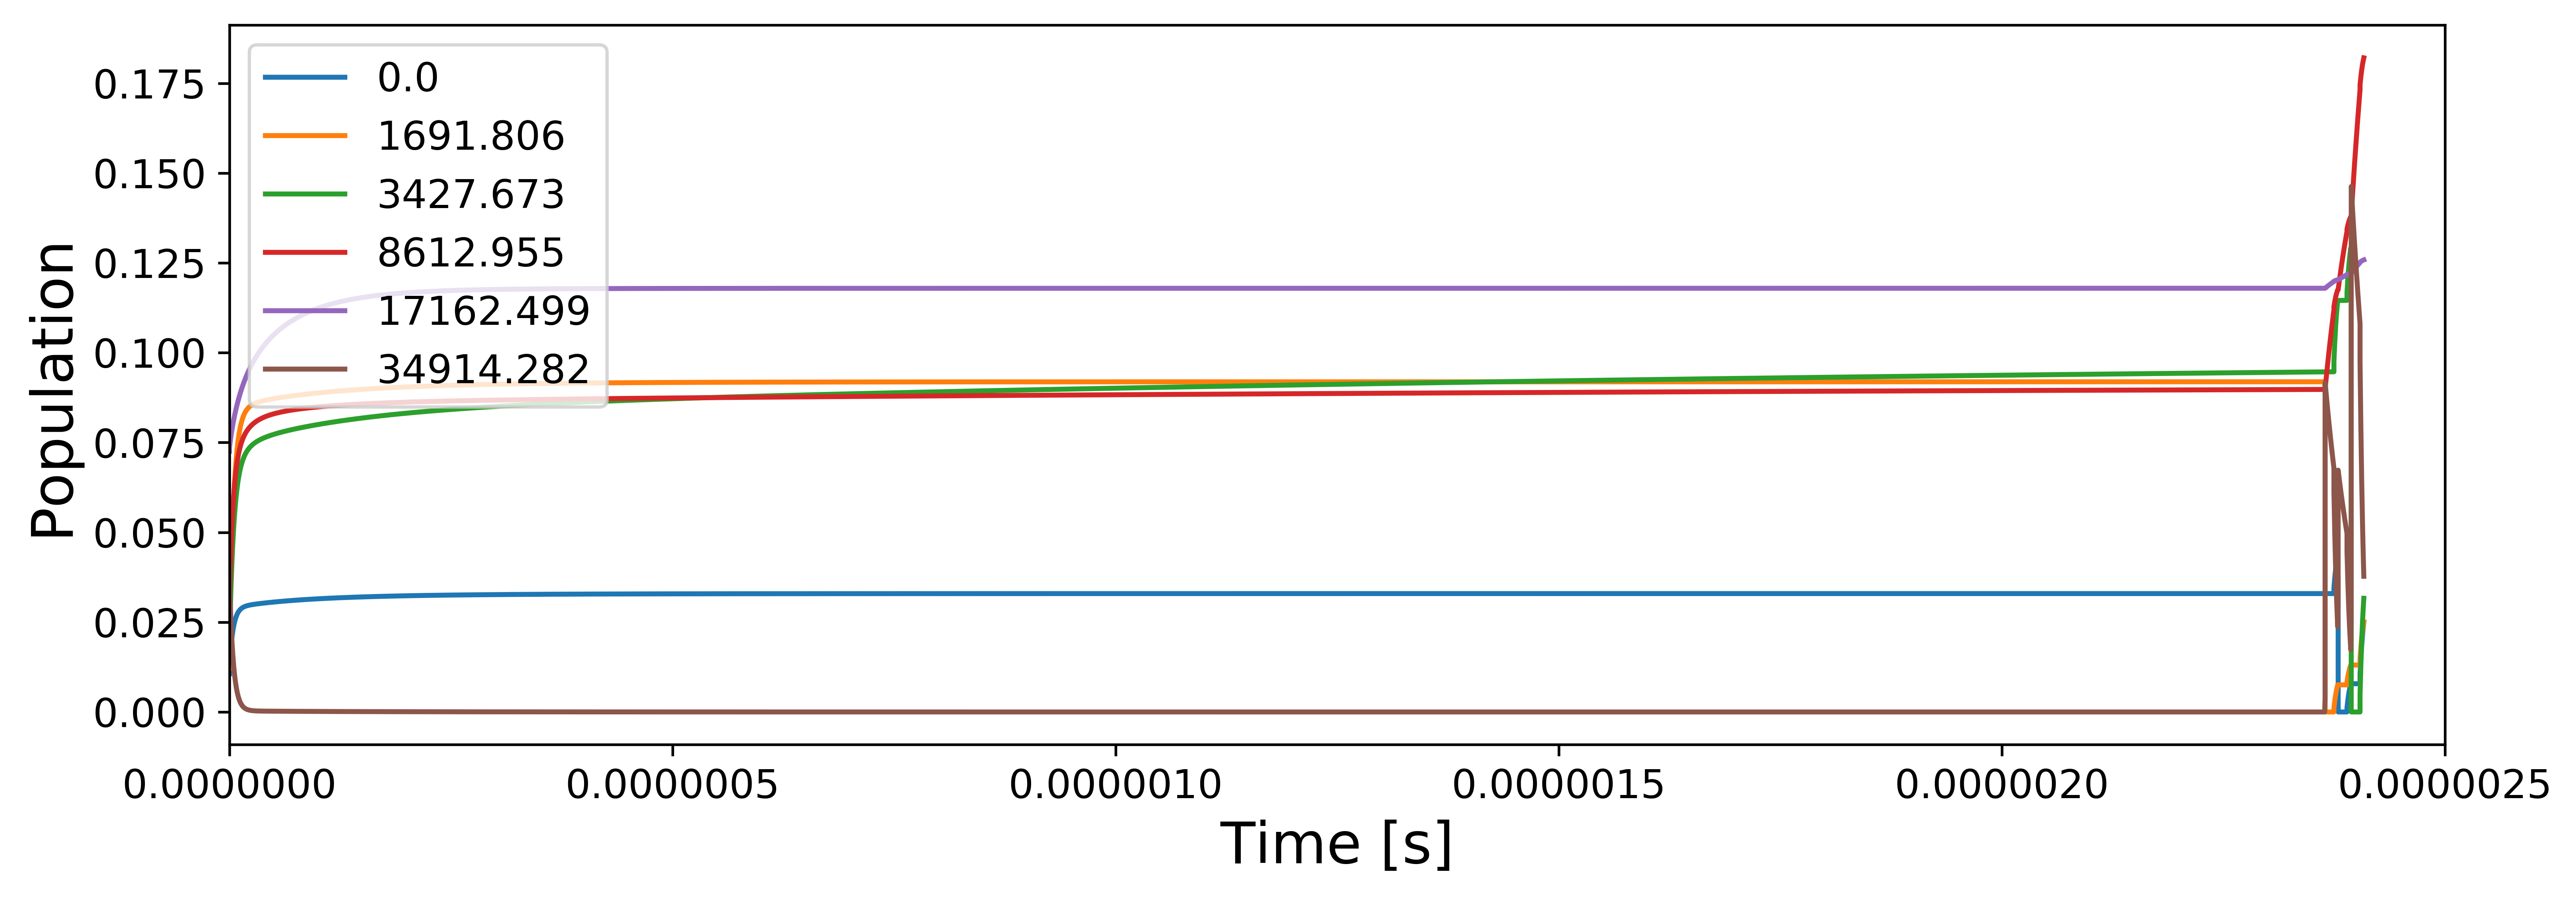

In [175]:
for i in range(6):
    plt.plot(tvec_K,pops_K[i])
plt.ylabel('Population')
plt.xlabel('Time [s]')
plt.legend(['0.0','1691.806','3427.673','8612.955','17162.499','34914.282'])
plt.xlim([0,0.0000025])
plt.show()

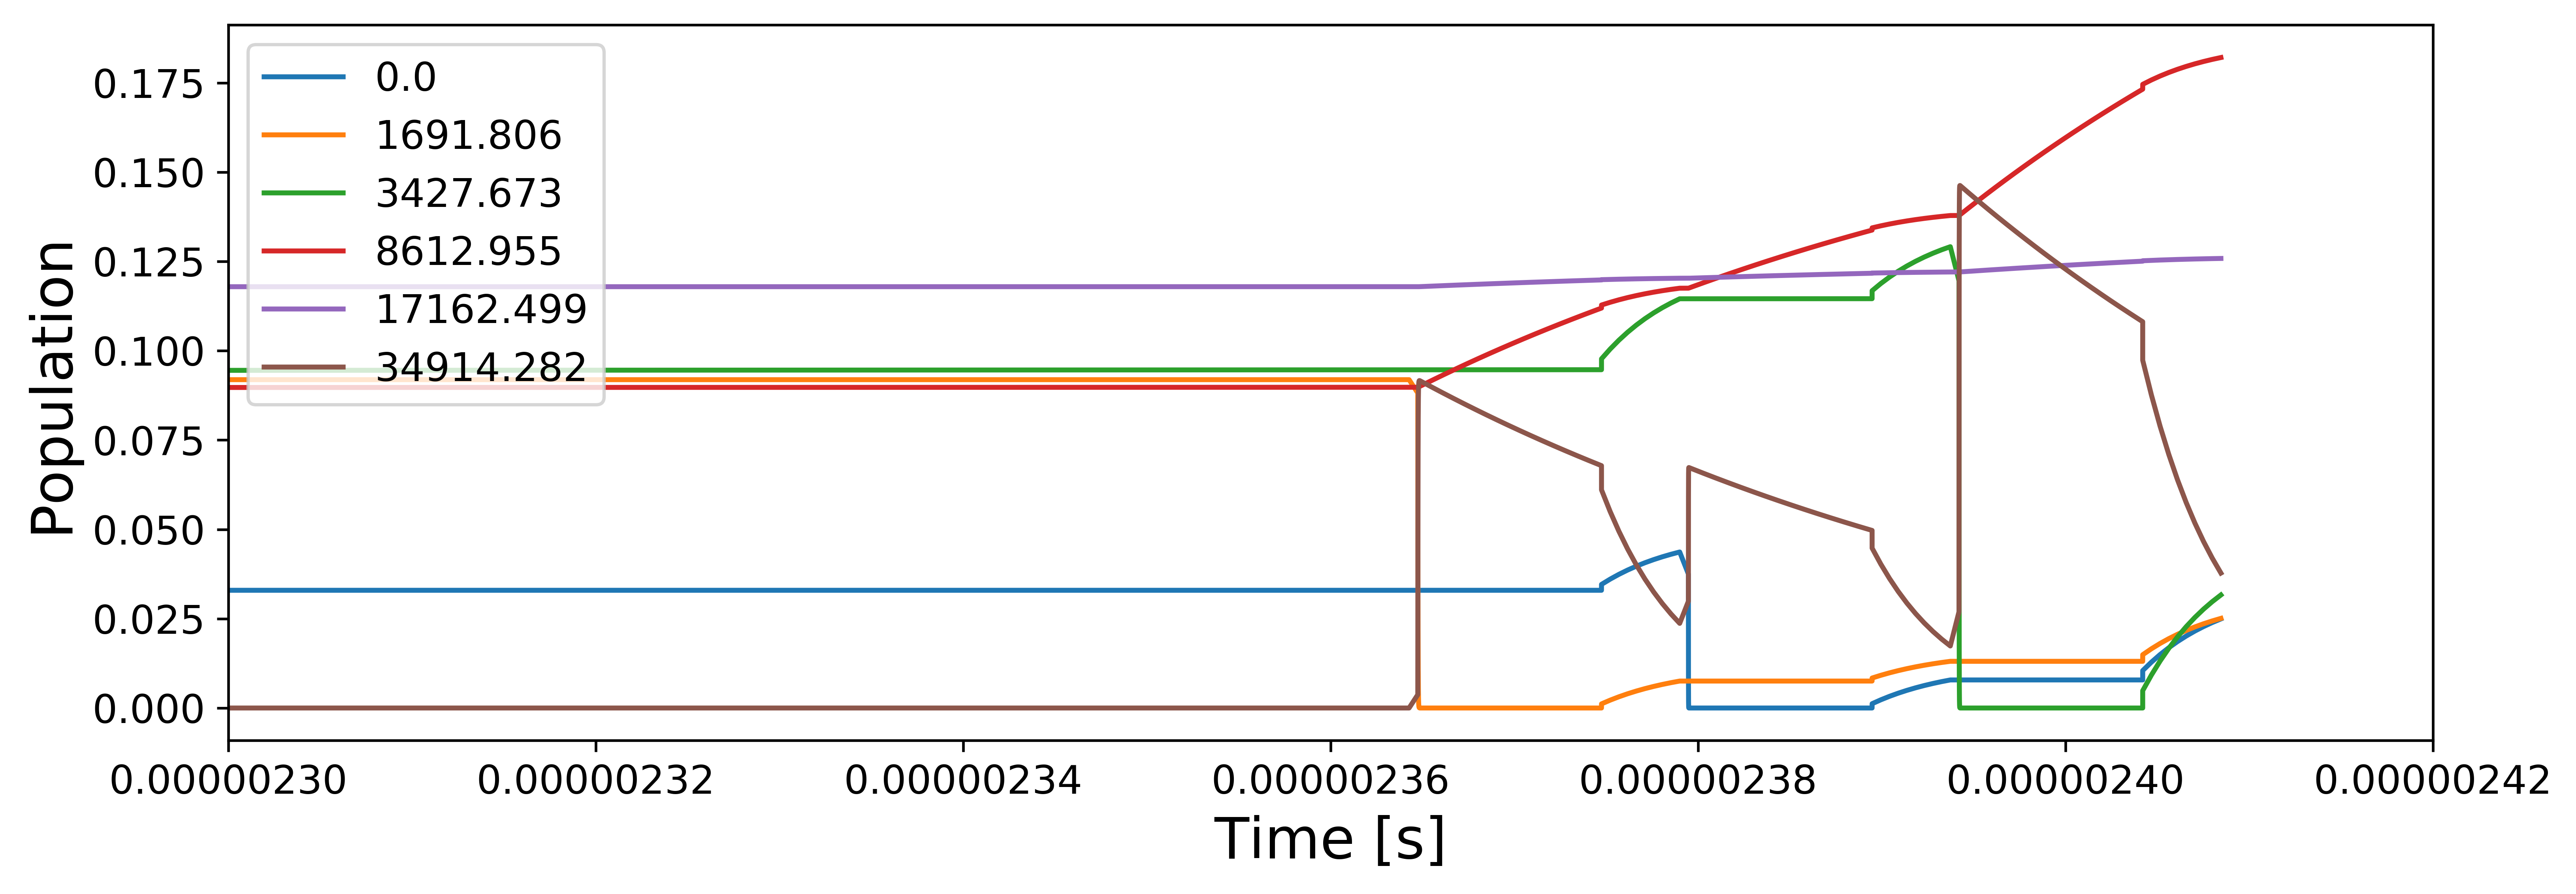

In [178]:
for i in range(6):
    plt.plot(tvec_K,pops_K[i])
plt.xlim([0.0000023,0.00000242])
plt.ylabel('Population')
plt.xlabel('Time [s]')
plt.legend(['0.0','1691.806','3427.673','8612.955','17162.499','34914.282'])
plt.show()

In [181]:
pumping_Na, pops_Na, tvec_Na = solver_vec(einstein_coeff,init_pop_Na,tof,10001,pumpab=[3,1,4],pumpstart=0.5*tof,pumping=True)

<class 'int'>
3
1 6 [0, 1, 2, 3, 4, 6]
<class 'int'>
3
<class 'int'>
1
<class 'int'>
4
2.6562953225894858633e-17


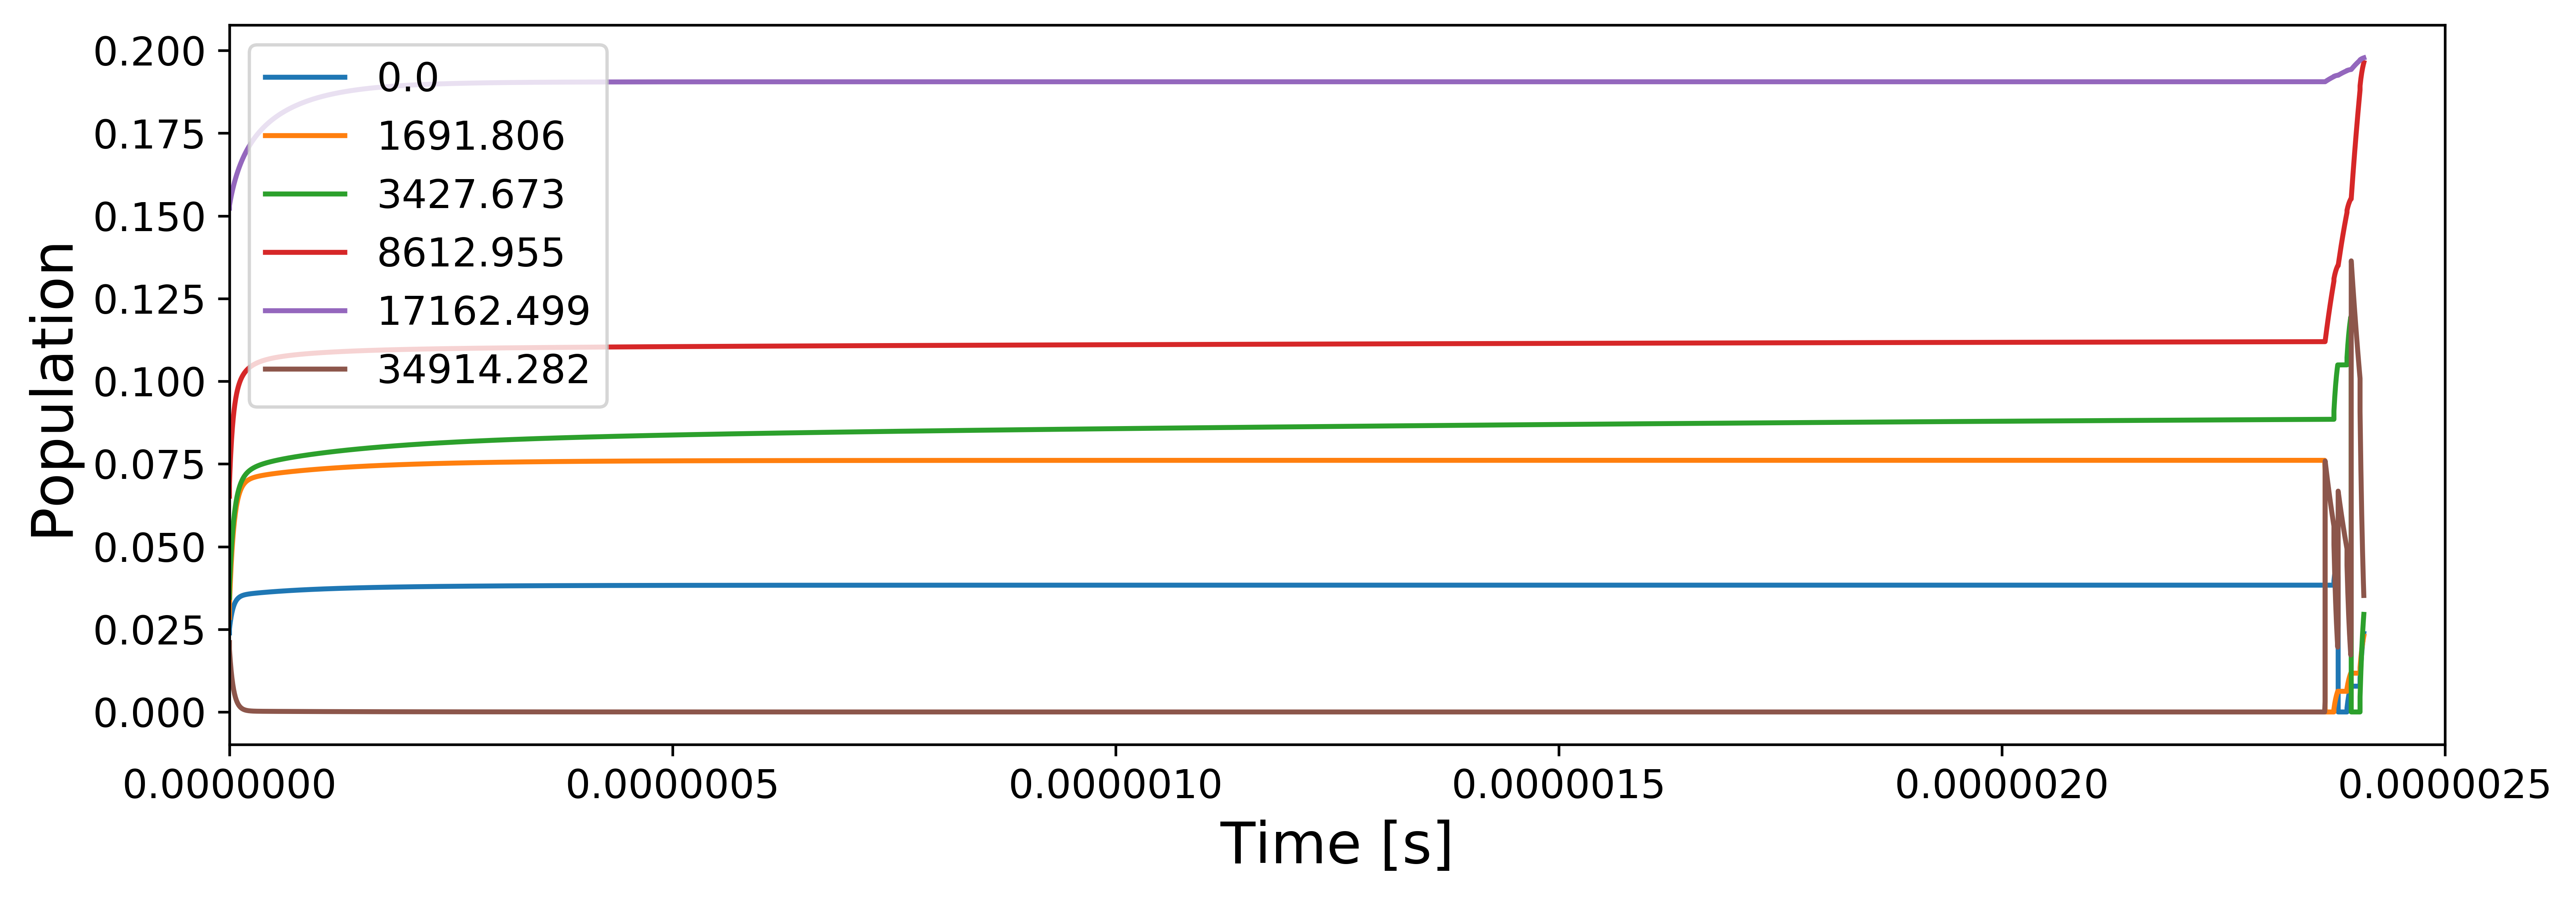

In [182]:
for i in range(6):
    plt.plot(tvec_Na,pops_Na[i])
plt.ylabel('Population')
plt.xlabel('Time [s]')
plt.xlim([0,0.0000025])
plt.legend(['0.0','1691.806','3427.673','8612.955','17162.499','34914.282'])
plt.show()

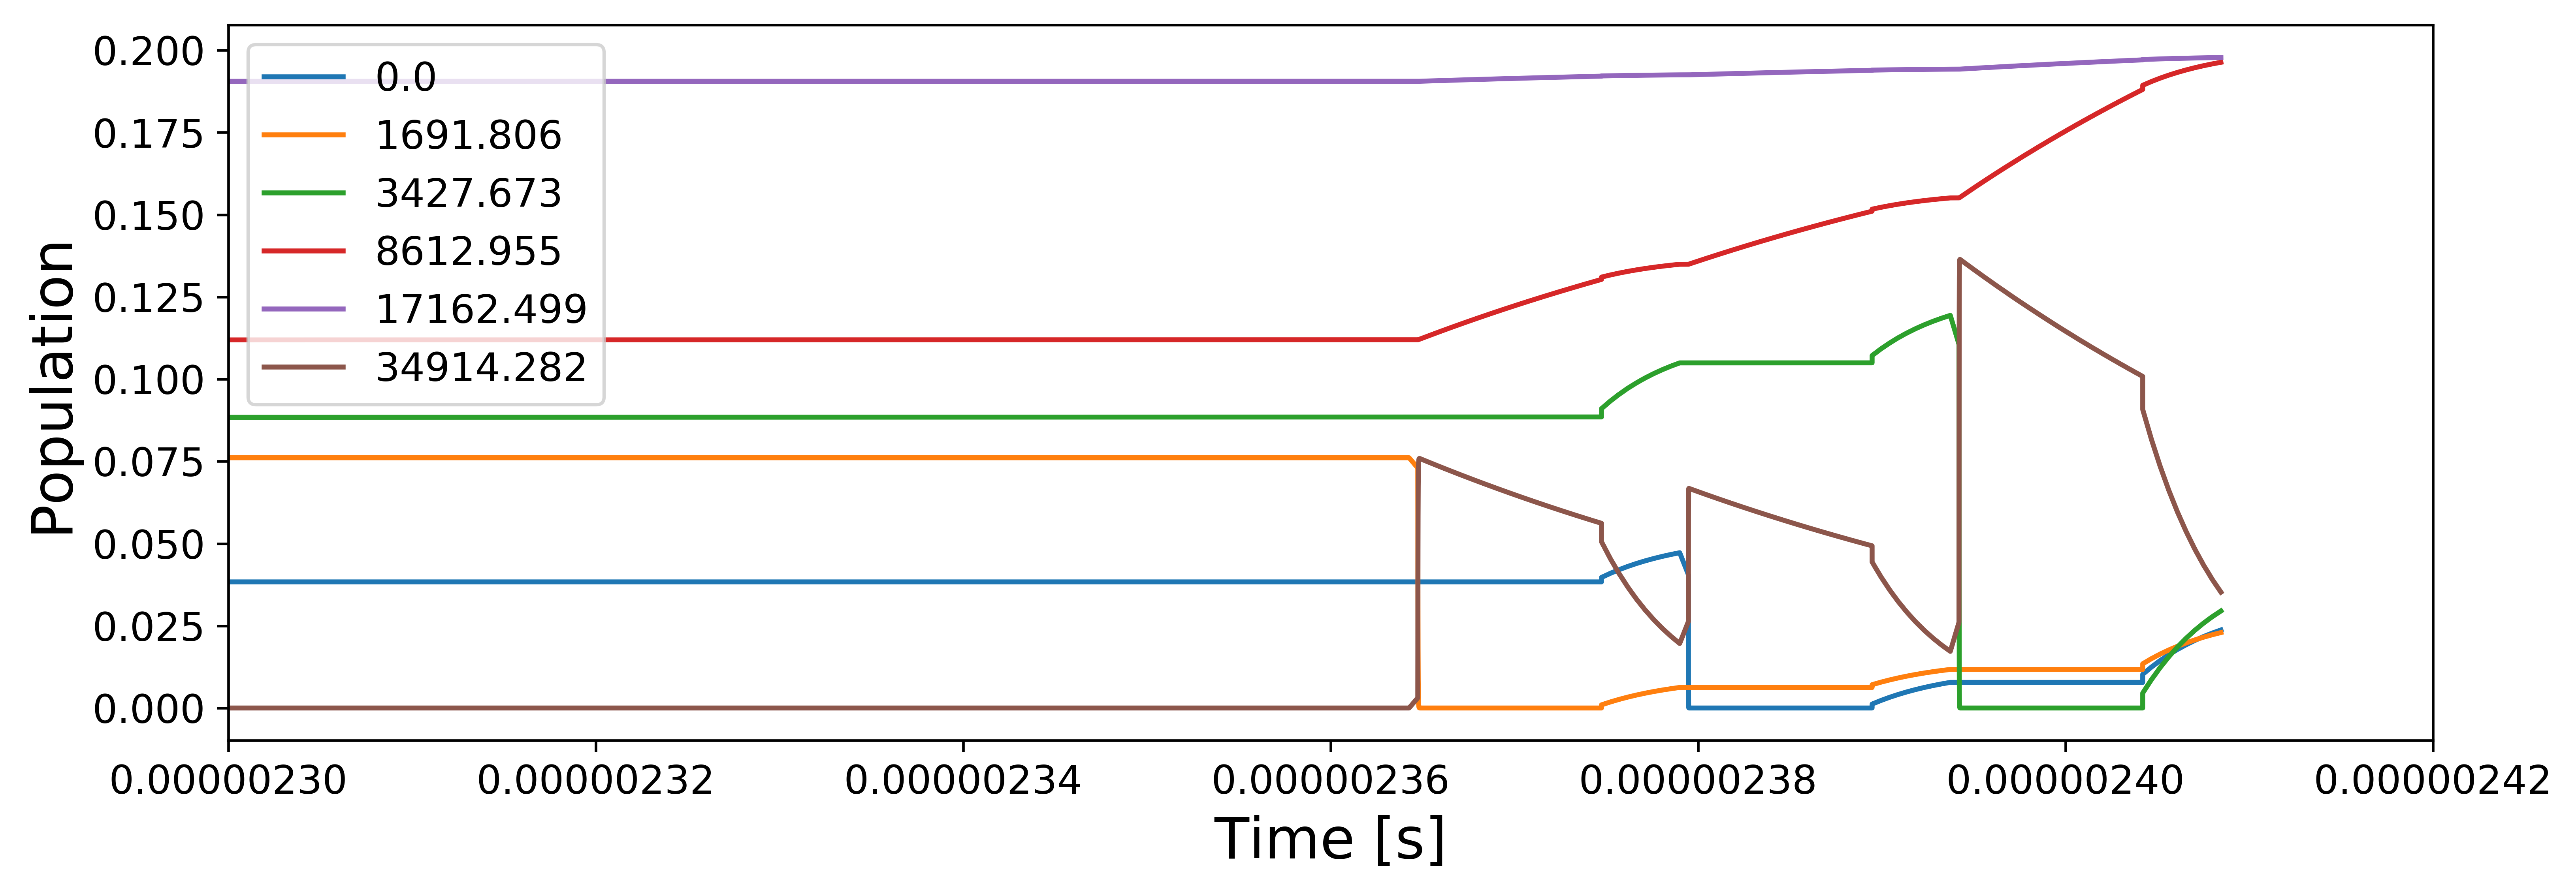

In [184]:
for i in range(6):
    plt.plot(tvec_Na,pops_Na[i])
# plt.vlines(0.5*tof,0,0.25)
plt.xlim([0.0000023,0.00000242])
plt.ylabel('Population')
plt.xlabel('Time [s]')
plt.legend(['0.0','1691.806','3427.673','8612.955','17162.499','34914.282'])
plt.show()

In [168]:
einstein_coeff.head(10)

,Ek,Ei,Aki,k,i,nAki,wavelength
0,34640.758,1691.806,200000000.0,5,1,1.000000,303.499790
1,34914.282,0.000,54000000.0,6,0,0.242806,286.415742
2,34914.282,17162.499,2400000.0,6,4,0.010791,563.323695
3,34914.282,1691.806,38000000.0,6,1,0.170863,301.001045
4,34914.282,3427.673,100000000.0,6,2,0.449640,317.595331
5,34914.282,8612.955,28000000.0,6,3,0.125899,380.208953
6,38628.876,3427.673,170000000.0,7,2,0.664062,284.081200
7,38628.876,1691.806,66000000.0,7,1,0.257812,270.730732
8,38628.876,8612.955,20000000.0,7,3,0.078125,333.156527
9,39257.053,1691.806,11000000.0,8,1,0.033537,266.203494


In [27]:
pumping_K1, pops_K1, tvec_K1 = solver_vec(einstein_coeff,init_pop_K,tof,10001,pumpab=[1,2,3,4,5],pumpstart=0.5*tof,pumping=True)

[1.04670384e+15 5.32185066e+14 9.95984774e+14 9.43944791e+14
 7.88493947e+14]
rho 2.2458717640079327e-10
[2.0e+08 0.0e+00 0.0e+00 0.0e+00 0.0e+00 0.0e+00 1.7e+08 6.6e+07 2.0e+07
 1.1e+07 2.6e+07 2.1e+07 2.7e+08 1.2e+05 3.7e+05 2.1e+07 3.3e+07 3.1e+06
 1.2e+07 1.7e+08 1.1e+06 1.4e+07 1.6e+08 8.0e+05 4.1e+06 6.6e+07 1.8e+07
 1.5e+08 3.1e+07 2.9e+07 3.0e+07 4.5e+07 1.2e+08 4.7e+06 3.6e+06 7.4e+06
 5.6e+07 6.2e+07 1.9e+07 1.1e+06 2.5e+08 6.2e+07 1.8e+07 4.9e+06 4.6e+06
 6.3e+06 8.3e+07 2.0e+08 2.3e+07 1.4e+07 1.1e+07 5.0e+06 9.6e+06 3.4e+07
 1.7e+07]
[2.0e+08 5.4e+07 2.4e+06 3.8e+07 1.0e+08 2.8e+07 1.7e+08 6.6e+07 2.0e+07
 1.1e+07 2.6e+07 2.1e+07 2.7e+08 1.2e+05 3.7e+05 2.1e+07 3.3e+07 3.1e+06
 1.2e+07 1.7e+08 1.1e+06 1.4e+07 1.6e+08 8.0e+05 4.1e+06 6.6e+07 1.8e+07
 1.5e+08 3.1e+07 2.9e+07 3.0e+07 4.5e+07 1.2e+08 4.7e+06 3.6e+06 7.4e+06
 5.6e+07 6.2e+07 1.9e+07 1.1e+06 2.5e+08 6.2e+07 1.8e+07 4.9e+06 4.6e+06
 6.3e+06 8.3e+07 2.0e+08 2.3e+07 1.4e+07 1.1e+07 5.0e+06 9.6e+06 3.4e+07
 1.7e+07]

## Let's test the solver
We need:
1. An initial population
2. Einstein coefficients
3. Spin of the levels
4. Time of flight
5. Levels we want to pump from an ordering
6. Maximum possible population of each level to benchmark results

Lets start with reading in the initial populations for the two alkalis in the CHarge Exchange Cell (CEC):
- Sodium 
- Potassium

at 40 keV

In [25]:
files = rs.name_dat_file('comp')
init_pop_Na = rs.read_population(files[-2])
init_pop_K = rs.read_population(files[-1])
files

['/home/hannahcb/cern/ode-solver/comp/SnIcm-1.nist',
 '/home/hannahcb/cern/ode-solver/comp/SnIlinescm-1.nist',
 '/home/hannahcb/cern/ode-solver/comp/final_populations_SnI.0',
 '/home/hannahcb/cern/ode-solver/comp/initial_cross_sections.0',
 '/home/hannahcb/cern/ode-solver/comp/xlevels_csSnI_Na_40000.0_120.0',
 '/home/hannahcb/cern/ode-solver/comp/xlevels_csSn_K_40000.0_120.0']

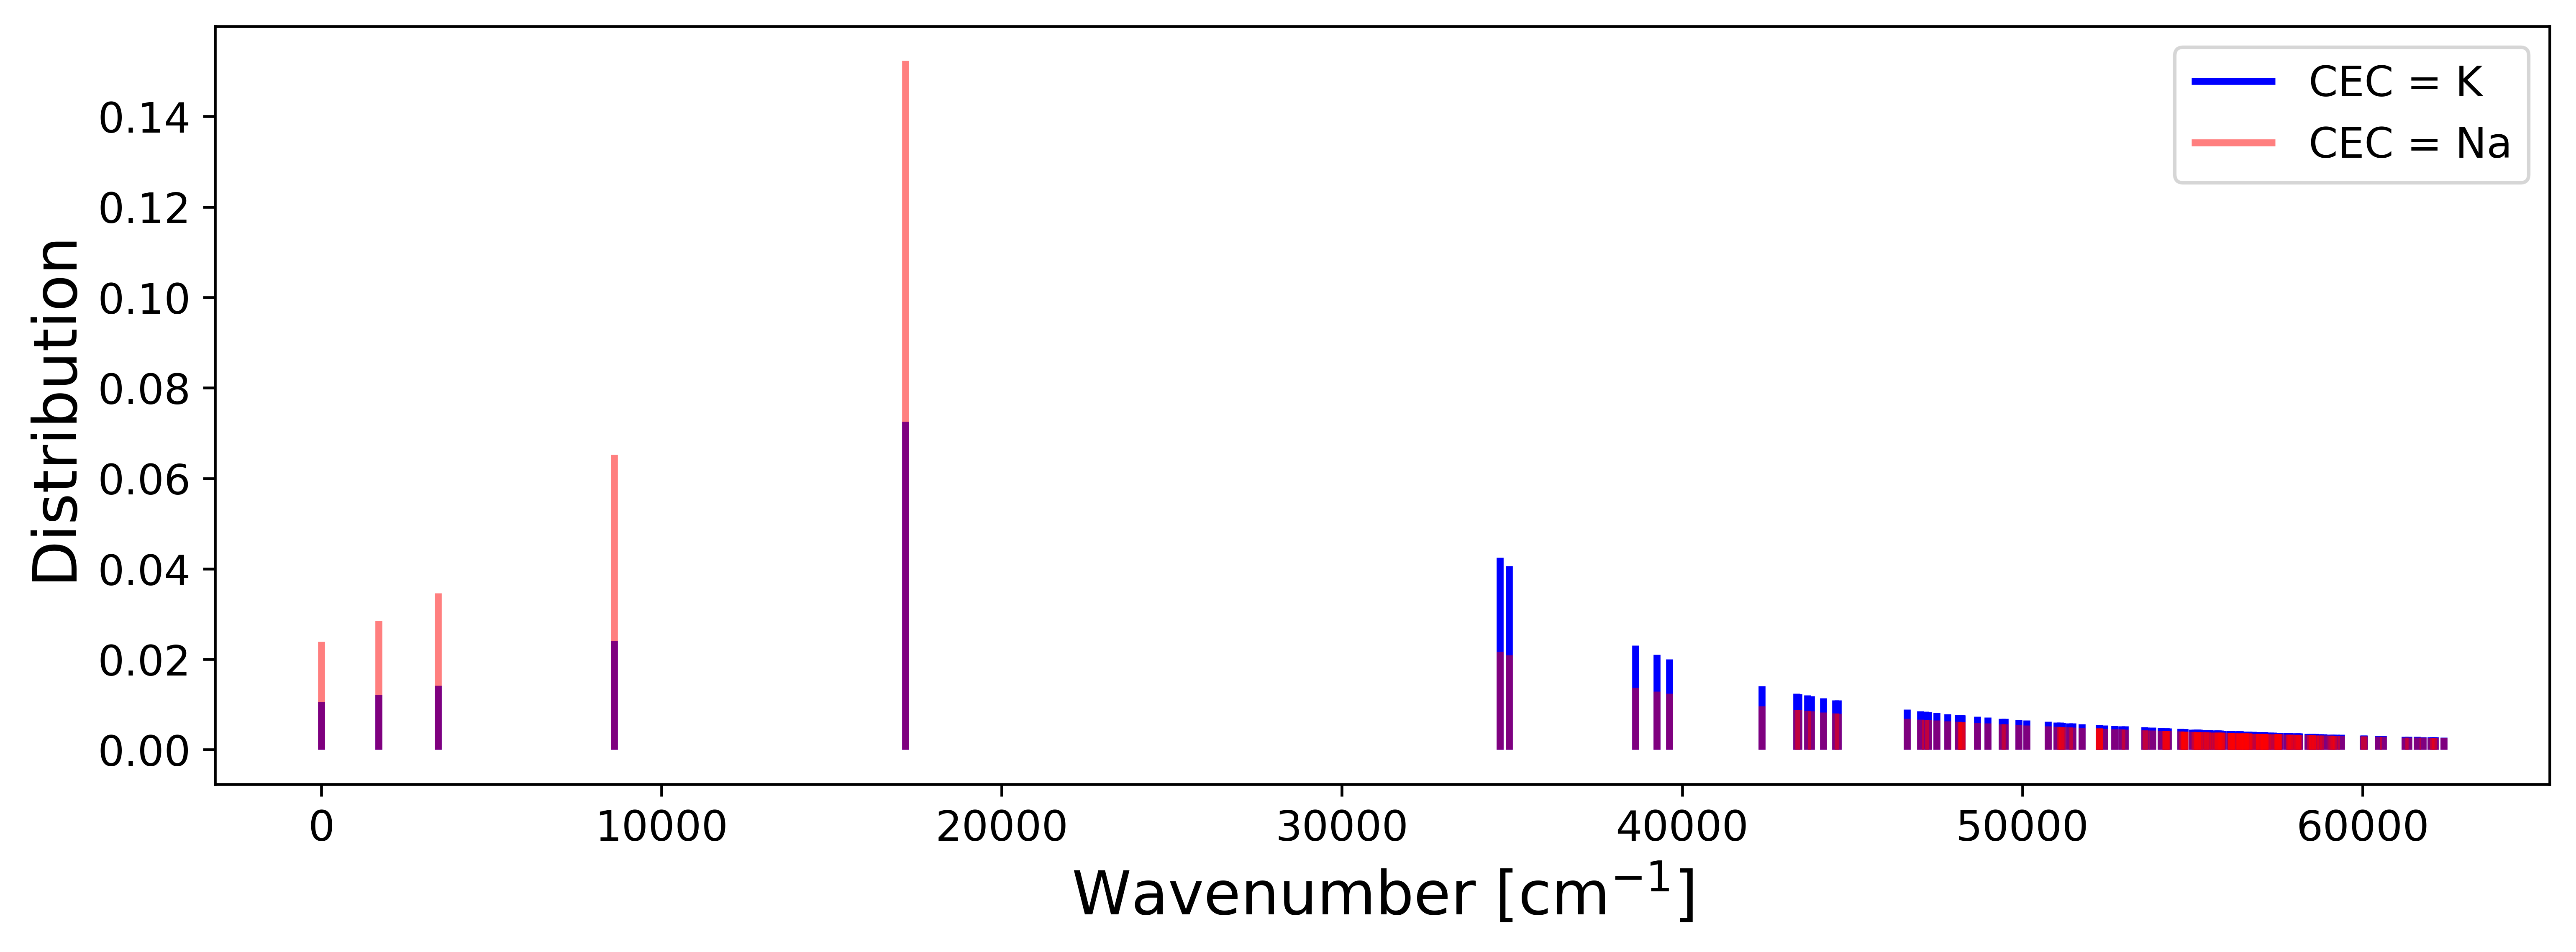

In [185]:
plt.vlines(init_pop_K['level'],0,init_pop_K['pop'],'b',label='CEC = K',linewidth=2)
plt.vlines(init_pop_Na['level'],0,init_pop_Na['pop'],'r',label='CEC = Na',linewidth=2,alpha=0.5)
plt.ylabel(r'Distribution')
plt.xlabel(r'Wavenumber [cm$^{-1}$]')
plt.legend(loc='upper right')
plt.show()

### Onto finding the Einstein coefficients

In [27]:
einstein_coeff_temp = rs.read_to_df3(files[1])
einstein_coeff_temp2 = rs.einsteindf(einstein_coeff_temp,init_pop_K)
einstein_coeff = normal_Einstein(einstein_coeff_temp2)

$E_k$ is the upper level, $E_i$ lower level, $A_{ki}$ is the related Einstein coefficient and $nA_{ki}$ is the normalized Einstein coefficient from the level $k$

In [28]:
einstein_coeff['wavelength'] = (1/(einstein_coeff.Ek-einstein_coeff.Ei))*1e-2*1e9

### Spin of the levels

In [29]:
nistFiles = rs.name_dat_file('newnist')
newn2 = rs.read_to_df3(nistFiles[0]) 
newn2.sort_values(by='Ek').reset_index(drop=True)

,observed wavelength,ritz wavelength,rel. int.,Aki,Acc,Ei,l_configuration,l_term,l_J,u_configuration,u_term,u_J,type,tp ref.,line ref.,Ek
0,303.41150,303.41148,10000r,200000000.0,D,1691.806,5s2.5p2,3P,1.0,5s2.5p.6s,3P,0.0,NaN,T4515,"L3149,L7378",34640.758
1,286.33147,286.33166,10000r,54000000.0,D,0.000,5s2.5p2,3P,0.0,5s2.5p.6s,3P,1.0,NaN,T4515,"L3149,L7378",34914.282
2,563.16758,563.16738,270,2400000.0,D,17162.499,5s2.5p2,1S,0.0,5s2.5p.6s,3P,1.0,NaN,T4515,"L3149,L7378",34914.282
3,300.91333,300.91335,12000r,38000000.0,D,1691.806,5s2.5p2,3P,1.0,5s2.5p.6s,3P,1.0,NaN,T4515,"L3149,L7378",34914.282
4,317.50354,317.50348,15000r,100000000.0,D,3427.673,5s2.5p2,3P,2.0,5s2.5p.6s,3P,1.0,NaN,T4515,"L3149,L7378",34914.282
5,380.10108,380.10104,6900r,28000000.0,D,8612.955,5s2.5p2,1D,2.0,5s2.5p.6s,3P,1.0,NaN,T4515,"L3149,L7378",34914.282
6,283.99765,283.99769,13000r,170000000.0,D,3427.673,5s2.5p2,3P,2.0,5s2.5p.6s,3P,2.0,NaN,T4515,"L3149,L7378",38628.876
7,270.65049,270.65047,11000r,66000000.0,D,1691.806,5s2.5p2,3P,1.0,5s2.5p.6s,3P,2.0,NaN,T4515,"L3149,L7378",38628.876
8,333.06072,333.06073,4700,20000000.0,D,8612.955,5s2.5p2,1D,2.0,5s2.5p.6s,3P,2.0,NaN,T4515,"L3149,L7378",38628.876
9,266.12436,266.12432,3700r,11000000.0,D,1691.806,5s2.5p2,3P,1.0,5s2.5p.6s,1P,1.0,NaN,T4515,"L3149,L7378",39257.053


In [30]:
window = signal.gaussian(51, std=7)

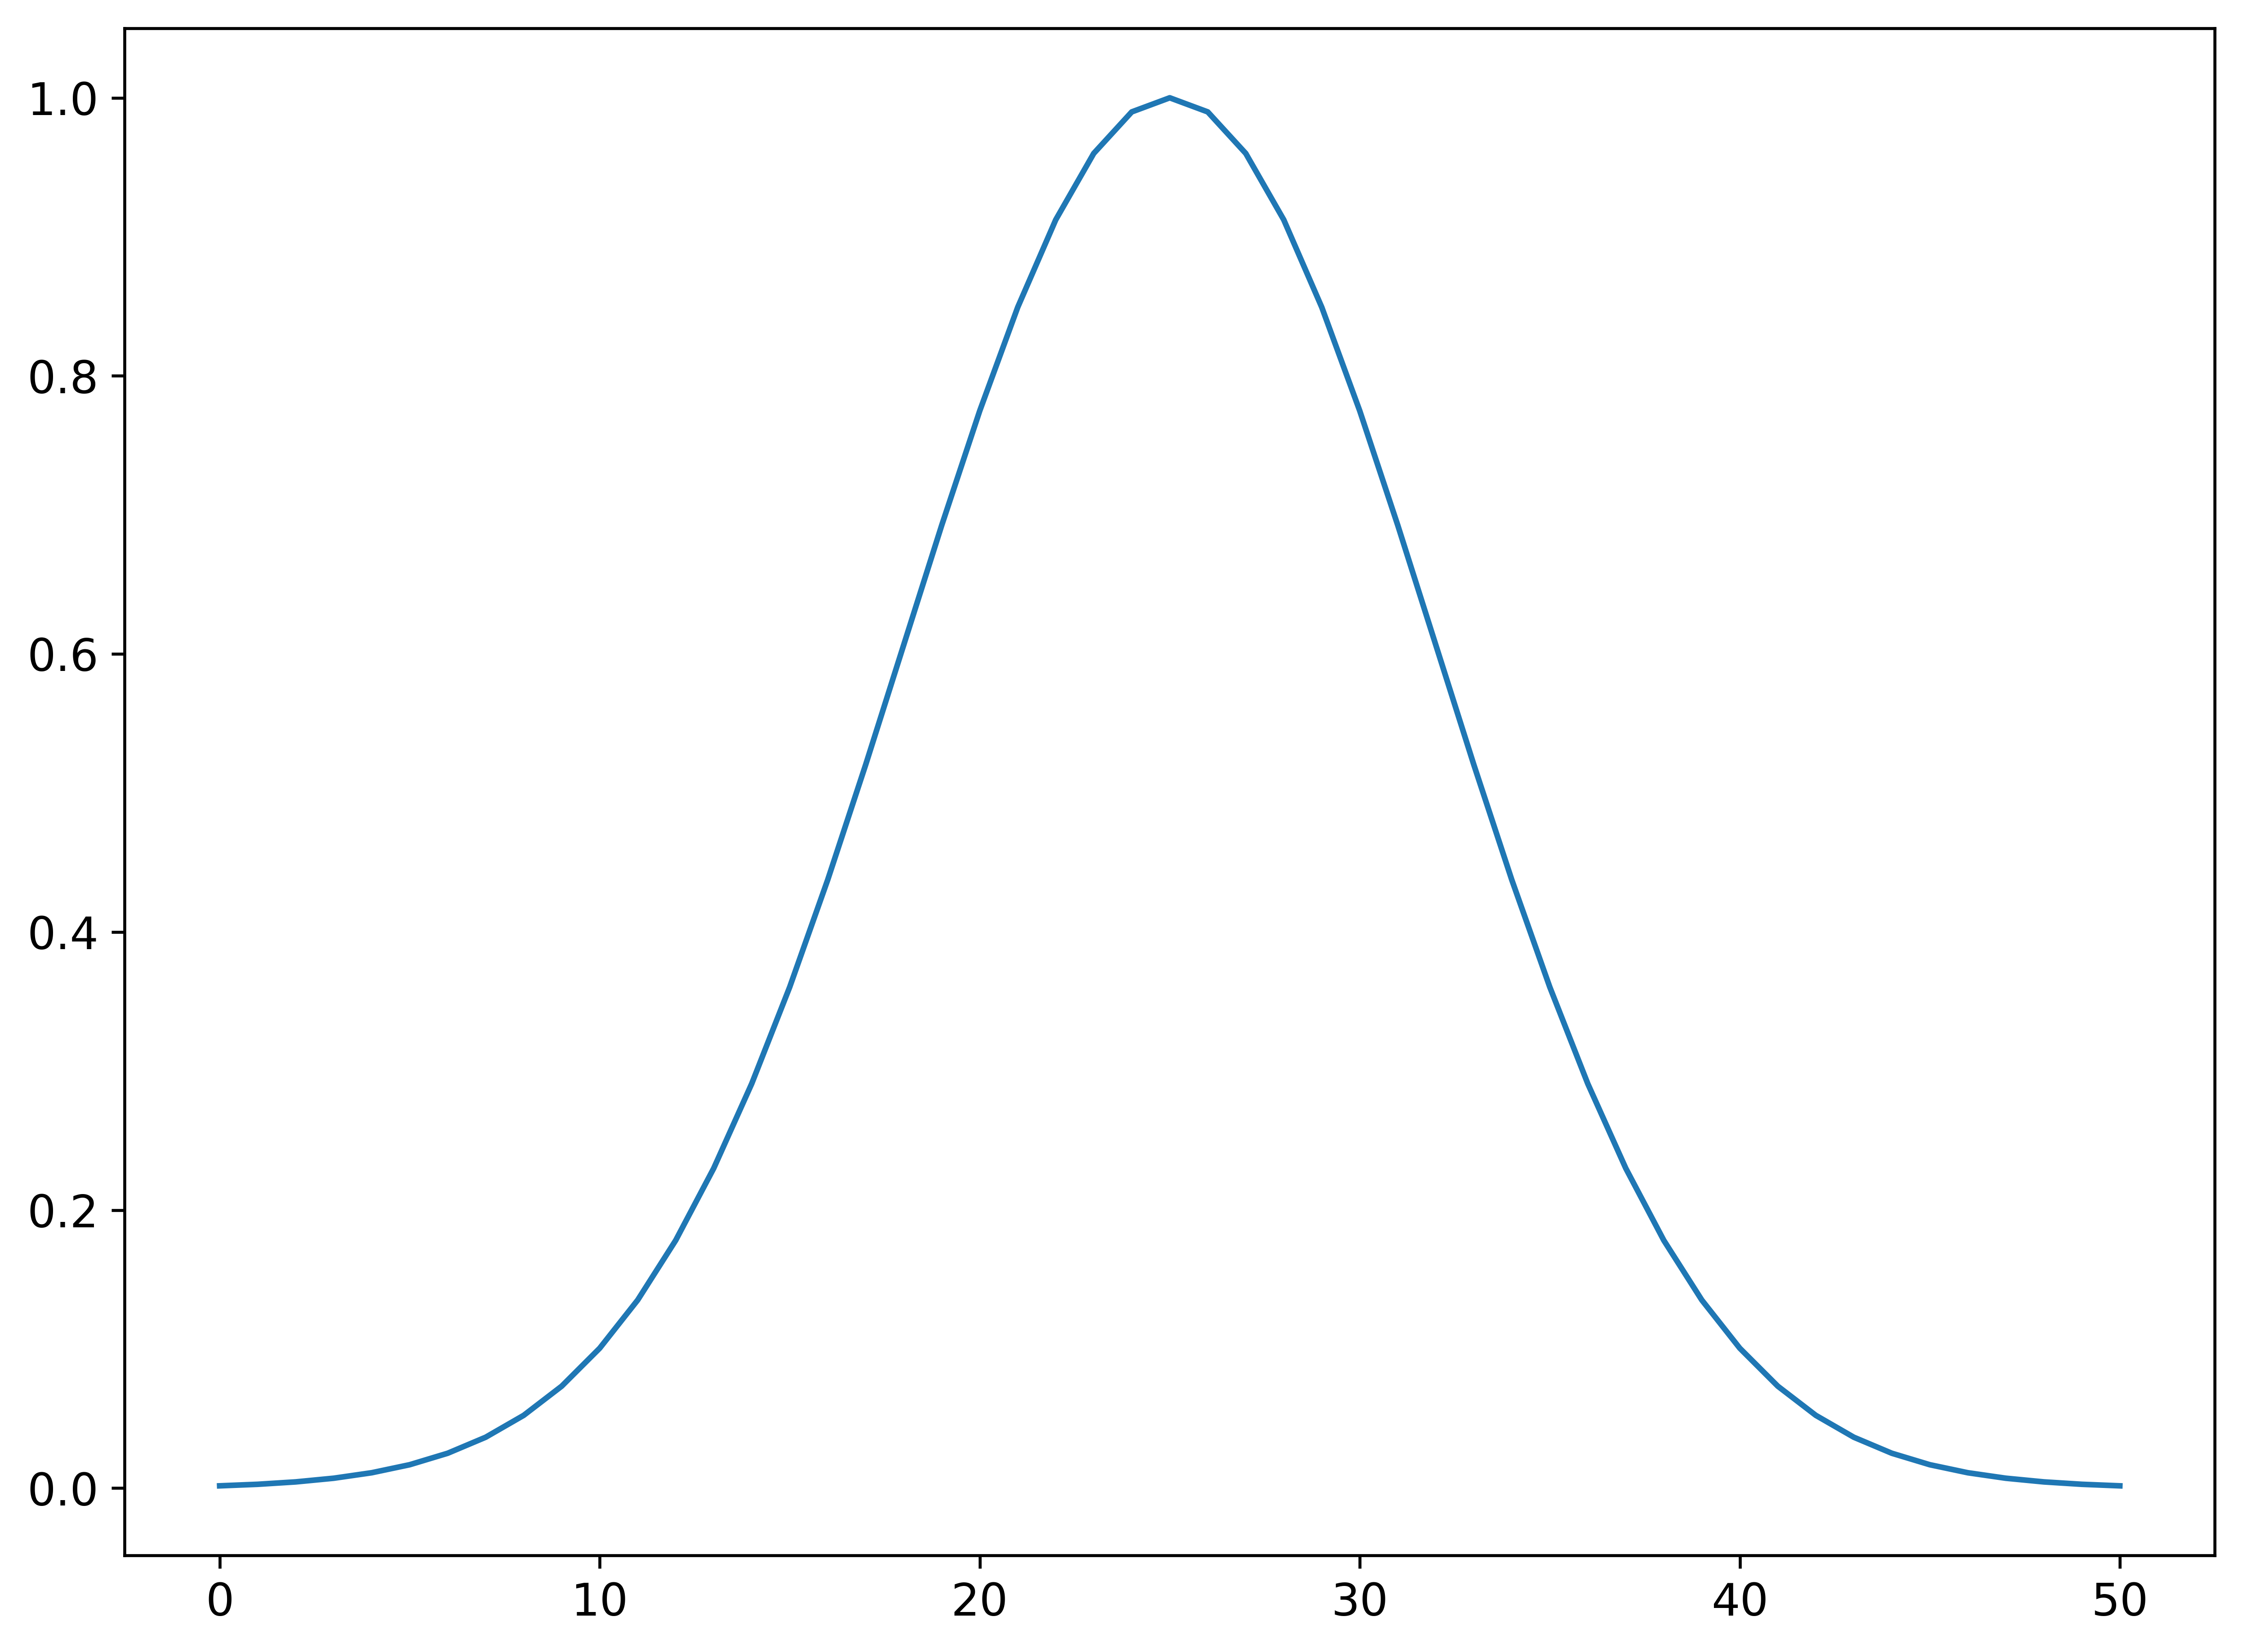

In [31]:
plt.plot(window)
plt.show()

## Pumping one level

In [193]:
einstein_coeff.head(43).tail(10)

,Ek,Ei,Aki,k,i,nAki,wavelength
33,48222.159,17162.499,4700000.0,27,4,0.299363,321.961026
34,48222.159,0.000,3600000.0,27,0,0.229299,207.373544
35,48222.159,8612.955,7400000.0,27,3,0.471338,252.466573
36,48669.409,3427.673,56000000.0,28,2,0.474576,221.034843
37,48669.409,8612.955,62000000.0,28,3,0.525424,249.647660
38,48981.934,17162.499,19000000.0,29,4,0.945274,314.273336
39,48981.934,8612.955,1100000.0,29,3,0.054726,247.714960
40,49893.823,8612.955,250000000.0,32,3,1.000000,242.242968
41,50125.971,17162.499,62000000.0,33,4,0.775000,303.366102
42,50125.971,8612.955,18000000.0,33,3,0.225000,240.888304


In [229]:
pumping_K1, pops_K1, tvec_K1 = solver_vec(einstein_coeff,init_pop_K,tof,10001,pumpab=[39],pumpstart=0.5*tof,pumping=True)

<class 'int'>
39
3 29 [0, 1, 2, 3, 4, 29]
<class 'int'>
39
6.1311632854055275743e-17
6.1691103614425202295e-17


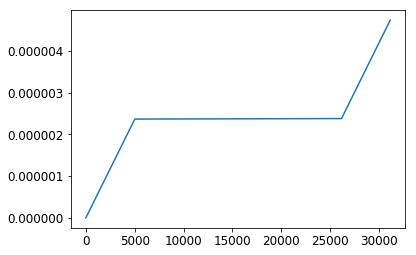

In [231]:
plt.plot(tvec_K1)

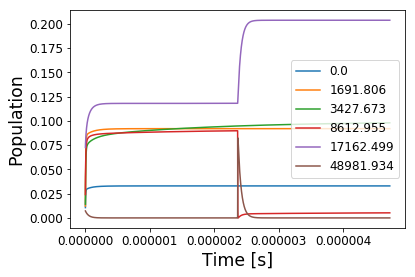

In [233]:
for i in range(6):
    plt.plot(tvec_K1[:-1],pops_K1[i][:-1])
# plt.vlines(0.5*tof,0,0.25)
# plt.xlim([0.0000023,0.00000237])
plt.ylabel('Population')
plt.xlabel('Time [s]')
plt.legend(['0.0','1691.806','3427.673','8612.955','17162.499','48981.934'])
plt.show()

In [234]:
pumping_Na1, pops_Na1, tvec_Na1 = solver_vec(einstein_coeff,init_pop_Na,tof,10001,pumpab=[39],pumpstart=0.5*tof,pumping=True)

<class 'int'>
39
3 29 [0, 1, 2, 3, 4, 29]
<class 'int'>
39
2.4502969098172400209e-17
2.4502969098172400209e-17


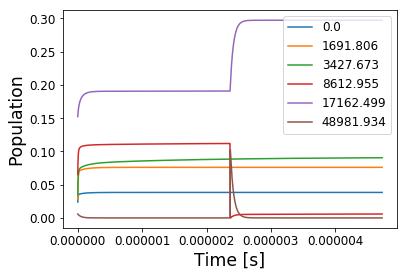

In [235]:
for i in range(6):
    plt.plot(tvec_Na1,pops_Na1[i])
# plt.vlines(0.5*tof,0,0.25)
# plt.xlim([0.0000023,0.00000238])
plt.ylabel('Population')
plt.xlabel('Time [s]')
plt.legend(['0.0','1691.806','3427.673','8612.955','17162.499','48981.934'])
plt.show()

Text(0.5,0,'Wavenumber [cm$^{-1}$]')

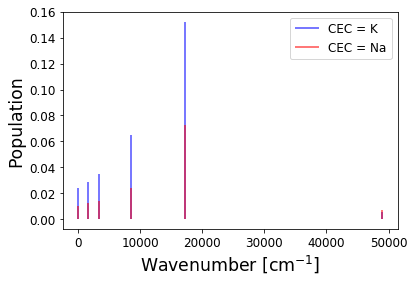

In [247]:
lines = [0.0,1691.806,3427.673,8612.955,17162.499,48981.934]
for i in range(6):
    plt.vlines(lines[i],0,pops_Na1[i][-1],'b',alpha=0.7)
    plt.vlines(lines[i],0,pops_K1[i][-1],'r',alpha=0.7)
plt.legend(['CEC = K','CEC = Na']) 
plt.ylabel('Population')
plt.xlabel('Wavenumber [cm$^{-1}$]')